# Huilin Chang (hc5hq), Gavin Wiehl (gtw4vx), Travis Vitello (tjv9qh)

## 8/2/2020

DS5559

NOTE: This notebook only considers the Amazon "Baby" data available here: http://jmcauley.ucsd.edu/data/amazon/

This notebook uses PySpark to process reviews, tokenize them, and the applies the wordcloud method in Python.

## Import Methods

In [1]:
import json

In [2]:
# from pyspark import SparkContext
# sc = SparkContext.getOrCreate()

In [3]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
from numpy import array
from math import sqrt
import requests

from pyspark.mllib.clustering import KMeans, KMeansModel

df = spark.read.json("reviews_Baby_5.json.gz")

In [5]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

## Typical Data

In [6]:
df.show(5)

+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|097293751X| [0, 0]|    5.0|Perfect for new p...|07 16, 2013|A1HK2FQW6KXQB2|Amanda Johnsen "A...|             Awesine|    1373932800|
|097293751X| [0, 0]|    5.0|This book is such...|06 29, 2013|A19K65VY14D13R|              angela|Should be require...|    1372464000|
|097293751X| [0, 0]|    5.0|Helps me know exa...|03 19, 2014|A2LL1TGG90977E|              Carter|Grandmother watch...|    1395187200|
|097293751X| [0, 0]|    5.0|I bought this a f...|08 17, 2013| A5G19RYX8599E|        cfpurplerose|        repeat buyer|    1376697600|
|097293751X| [0, 0]|    4.0|I wanted an alter...| 04 1, 2014| 

In [7]:
import json
import pandas as pd
data_df = pd.read_json('reviews_Baby_5.json.gz', lines=True)

## Explore Data

In [8]:
data_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5,Awesine,1373932800,"07 16, 2013"
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5,Should be required for all new parents!,1372464000,"06 29, 2013"
2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5,Grandmother watching baby,1395187200,"03 19, 2014"
3,A5G19RYX8599E,097293751X,cfpurplerose,"[0, 0]",I bought this a few times for my older son and...,5,repeat buyer,1376697600,"08 17, 2013"
4,A2496A4EWMLQ7,097293751X,C. Jeter,"[0, 0]",I wanted an alternative to printing out daily ...,4,Great,1396310400,"04 1, 2014"
...,...,...,...,...,...,...,...,...,...
160787,A30J0DKNKCF7SR,B00L13XFIE,SD,"[0, 0]",Bought this as a baby gift and my friend heard...,5,Great baby gift,1391126400,"01 31, 2014"
160788,AG4E44KM93P4L,B00L13XFIE,Silofish,"[0, 1]",I am new to cloth diapering. I was leery that ...,4,Not too bulky,1343606400,"07 30, 2012"
160789,A2UZUH4QHV4HA1,B00L13XFIE,"S. Smith ""sunnshyne309""","[0, 0]",My friend is planning on cloth diapering and I...,5,great help!,1364256000,"03 26, 2013"
160790,A2Z26PUQPMT5JV,B00L13XFIE,Stephanie S. Kim,"[0, 0]",We LOVE the organic cotton/hemp inserts. They'...,5,Love these diapers!,1391731200,"02 7, 2014"


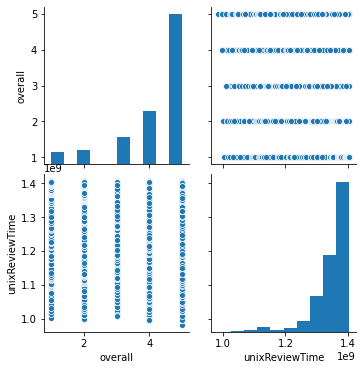

In [9]:
import seaborn as sns
sns.pairplot(data_df)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


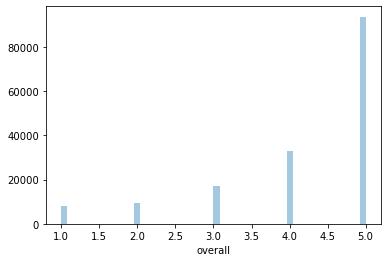

In [10]:
from matplotlib import pyplot as plt
sns.distplot(data_df['overall'],kde = False)
plt.show()

In [11]:
data_df.count()

reviewerID        160792
asin              160792
reviewerName      159427
helpful           160792
reviewText        160792
overall           160792
summary           160792
unixReviewTime    160792
reviewTime        160792
dtype: int64

In [12]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

In [13]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [14]:
df_n = df.select("reviewText")

In [15]:
df.describe("overall").show()

+-------+-----------------+
|summary|          overall|
+-------+-----------------+
|  count|           160792|
|   mean|4.214115130105975|
| stddev|1.144324709108409|
|    min|              1.0|
|    max|              5.0|
+-------+-----------------+



## Remove netutal: overall = 3

In [16]:
df1 = df.filter("overall != 3")

In [17]:
from pyspark.ml.feature import Bucketizer
splits = [-float("inf"), 4, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="overall", outputCol="label")

In [18]:
df2= bucketizer.transform(df1)

In [19]:
df2.groupBy("overall","label").count().show()

+-------+-----+-----+
|overall|label|count|
+-------+-----+-----+
|    2.0|  0.0| 9193|
|    5.0|  1.0|93526|
|    1.0|  0.0| 7819|
|    4.0|  1.0|32999|
+-------+-----+-----+



In [20]:
df3 = df2.groupBy("reviewText","label").count().show()

+--------------------+-----+-----+
|          reviewText|label|count|
+--------------------+-----+-----+
|This item was ext...|  1.0|    1|
|This has been my ...|  1.0|    1|
|We bought these t...|  1.0|    1|
|I was skeptical a...|  1.0|    1|
|In registering an...|  1.0|    1|
|You cannot imagin...|  1.0|    1|
|We needed a gate ...|  1.0|    1|
|This fits well an...|  1.0|    1|
|Easy to install. ...|  1.0|    1|
|This tub is perfe...|  1.0|    1|
|These work great ...|  1.0|    1|
|We have had this ...|  1.0|    1|
|I used to have on...|  1.0|    1|
|These bugs are a ...|  1.0|    1|
|Don't read negati...|  1.0|    1|
|I bought these bo...|  0.0|    1|
|My daughter was n...|  1.0|    1|
|I initially got t...|  1.0|    1|
|I'm not sure if i...|  1.0|    1|
|i love this seat!...|  1.0|    1|
+--------------------+-----+-----+
only showing top 20 rows



## train, test split

In [21]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF

In [22]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="reviewTokenUF")
regexTokenizer = RegexTokenizer(inputCol="reviewText", outputCol="reviewTokenUF", pattern="\s+|[,.()'!?\"]")

In [23]:
df_tokenized = tokenizer.transform(df2)

In [24]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="reviewTokenUF", outputCol="filtered")

In [25]:
df_removed = remover.transform(df_tokenized)

In [26]:
df_removed.take(2)

[Row(asin='097293751X', helpful=[0, 0], overall=5.0, reviewText="Perfect for new parents. We were able to keep track of baby's feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!", reviewTime='07 16, 2013', reviewerID='A1HK2FQW6KXQB2', reviewerName='Amanda Johnsen "Amanda E. Johnsen"', summary='Awesine', unixReviewTime=1373932800, label=1.0, reviewTokenUF=['perfect', 'for', 'new', 'parents.', 'we', 'were', 'able', 'to', 'keep', 'track', 'of', "baby's", 'feeding,', 'sleep', 'and', 'diaper', 'change', 'schedule', 'for', 'the', 'first', 'two', 'and', 'a', 'half', 'months', 'of', 'her', 'life.', 'made', 'life', 'easier', 'when', 'the', 'doctor', 'would', 'ask', 'questions', 'about', 'habits', 'because', 'we', 'had', 'it', 'all', 'right', 'there!'], filtered=['perfect', 'new', 'parents.', 'able', 'keep', 'track', "baby's", 'feeding,', 'sleep', 'diaper',

In [28]:
# Convert to TF words vector
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
df_TF = hashingTF.transform(df_removed)

In [29]:
df_TF.select(['asin','reviewerID','filtered','rawFeatures']).take(2)

[Row(asin='097293751X', reviewerID='A1HK2FQW6KXQB2', filtered=['perfect', 'new', 'parents.', 'able', 'keep', 'track', "baby's", 'feeding,', 'sleep', 'diaper', 'change', 'schedule', 'first', 'two', 'half', 'months', 'life.', 'made', 'life', 'easier', 'doctor', 'ask', 'questions', 'habits', 'right', 'there!'], rawFeatures=SparseVector(262144, {9559: 1.0, 12602: 1.0, 15664: 1.0, 17252: 1.0, 19164: 1.0, 29945: 1.0, 32890: 1.0, 32957: 1.0, 63689: 1.0, 70418: 1.0, 81046: 1.0, 82111: 1.0, 92646: 1.0, 101464: 1.0, 105535: 1.0, 109810: 1.0, 118590: 1.0, 140784: 1.0, 143288: 1.0, 148313: 1.0, 166277: 1.0, 172517: 1.0, 216086: 1.0, 238301: 1.0, 238605: 1.0, 249593: 1.0})),
 Row(asin='097293751X', reviewerID='A19K65VY14D13R', filtered=['book', 'life', 'saver.', '', 'helpful', 'able', 'go', 'back', 'track', 'trends,', 'answer', 'pediatrician', 'questions,', 'communicate', 'different', 'times', 'night', 'newborn.', '', 'think', 'one', 'things', 'everyone', 'required', 'leave', 'hospital.', '', 'went

In [30]:
# Convert to TF*IDF words vector
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_TF)
df_idf = idfModel.transform(df_TF)

In [31]:
df_idf.select(['asin','reviewerID','filtered','features']).take(2)

[Row(asin='097293751X', reviewerID='A1HK2FQW6KXQB2', filtered=['perfect', 'new', 'parents.', 'able', 'keep', 'track', "baby's", 'feeding,', 'sleep', 'diaper', 'change', 'schedule', 'first', 'two', 'half', 'months', 'life.', 'made', 'life', 'easier', 'doctor', 'ask', 'questions', 'habits', 'right', 'there!'], features=SparseVector(262144, {9559: 6.8374, 12602: 3.1555, 15664: 2.3994, 17252: 4.0767, 19164: 6.0079, 29945: 2.9193, 32890: 2.3273, 32957: 5.8059, 63689: 3.2923, 70418: 3.3218, 81046: 2.1548, 82111: 2.2179, 92646: 3.6214, 101464: 2.707, 105535: 6.5084, 109810: 5.2437, 118590: 2.731, 140784: 2.6273, 143288: 8.0902, 148313: 6.4945, 166277: 6.1806, 172517: 4.1818, 216086: 8.0032, 238301: 2.6047, 238605: 2.6355, 249593: 5.8854})),
 Row(asin='097293751X', reviewerID='A19K65VY14D13R', filtered=['book', 'life', 'saver.', '', 'helpful', 'able', 'go', 'back', 'track', 'trends,', 'answer', 'pediatrician', 'questions,', 'communicate', 'different', 'times', 'night', 'newborn.', '', 'think',

In [32]:
for features_label in df_idf.select("features", "label").take(3):
    print(features_label)

Row(features=SparseVector(262144, {9559: 6.8374, 12602: 3.1555, 15664: 2.3994, 17252: 4.0767, 19164: 6.0079, 29945: 2.9193, 32890: 2.3273, 32957: 5.8059, 63689: 3.2923, 70418: 3.3218, 81046: 2.1548, 82111: 2.2179, 92646: 3.6214, 101464: 2.707, 105535: 6.5084, 109810: 5.2437, 118590: 2.731, 140784: 2.6273, 143288: 8.0902, 148313: 6.4945, 166277: 6.1806, 172517: 4.1818, 216086: 8.0032, 238301: 2.6047, 238605: 2.6355, 249593: 5.8854}), label=1.0)
Row(features=SparseVector(262144, {4089: 6.1606, 23717: 5.1848, 24145: 3.362, 24233: 7.2592, 26976: 6.2612, 27787: 13.4306, 32957: 5.8059, 37101: 4.6837, 51492: 8.8298, 60001: 10.4881, 66092: 3.365, 70028: 2.4275, 83756: 3.8868, 84077: 6.1739, 101464: 2.707, 111449: 5.9663, 118590: 2.731, 125372: 1.3064, 126017: 8.0242, 132270: 2.2609, 132538: 4.8156, 141522: 3.2376, 144620: 8.4732, 146139: 3.5622, 148067: 3.7606, 158845: 5.6923, 160043: 4.695, 160614: 9.3894, 172477: 2.5675, 172517: 4.1818, 176260: 4.0455, 176996: 2.5102, 181489: 6.5225, 189113:

# Count Vectorizer

In [35]:
from pyspark.ml.feature import CountVectorizer

In [36]:
count_vec = CountVectorizer(inputCol = "filtered", outputCol = "cv_features")

In [37]:
cv_df = count_vec.fit(df_removed).transform(df_removed)

In [38]:
cv_df.select(['asin','reviewerID','filtered','cv_features']).show(5,False)

+----------+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
count_vec.fit(df_removed).vocabulary

['',
 'baby',
 'one',
 'like',
 'use',
 'great',
 'little',
 'get',
 'love',
 'easy',
 'really',
 'also',
 'it.',
 'much',
 'seat',
 'put',
 'son',
 'bought',
 'still',
 'old',
 'used',
 'even',
 'good',
 'well',
 '-',
 'time',
 'months',
 'using',
 'daughter',
 'first',
 'back',
 'loves',
 'got',
 'car',
 'fit',
 'diaper',
 'keep',
 'two',
 'since',
 'around',
 'nice',
 'make',
 'enough',
 'think',
 'recommend',
 'need',
 '2',
 'stroller',
 'take',
 'product',
 'buy',
 'bag',
 'small',
 'without',
 'go',
 'way',
 'work',
 'month',
 'bottles',
 'works',
 'every',
 'big',
 'size',
 'made',
 'better',
 'perfect',
 'bottle',
 'it,',
 'hold',
 'thing',
 'see',
 'able',
 'soft',
 'bit',
 'never',
 'lot',
 'want',
 'right',
 'easily',
 '3',
 'sure',
 'pretty',
 'makes',
 'fits',
 'different',
 'long',
 'many',
 'hard',
 '4',
 'child',
 'seems',
 'getting',
 'another',
 'know',
 'side',
 'new',
 'clean',
 'play',
 'something',
 'tried',
 'water',
 'wish',
 'going',
 'find',
 'cover',
 'best',

# Text Classification

In [40]:
df_removed.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- label: double (nullable = true)
 |-- reviewTokenUF: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [41]:
df_removed.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0| 17012|
|  1.0|126525|
+-----+------+



In [42]:
from pyspark.sql.functions import rand

In [43]:
df_removed.select(['asin','filtered','label']).orderBy(rand()).show(3,False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|asin      |filtered                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |label|
+----------+--------------------------

In [44]:
from pyspark.sql.functions import length

In [45]:
df_removed = df_removed.withColumn('length',length(df_removed['reviewText']))

In [46]:
df_removed.select(['asin','filtered','length','label']).orderBy(rand()).show(3,False)

+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-----+
|asin      |filtered                                                                                                                                                                                                                                                                                                                               |length|label|
+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
df_removed.groupBy('label').agg({'length':'mean'}).show() # Get average review length, positive and negative

+-----+------------------+
|label|       avg(length)|
+-----+------------------+
|  0.0| 559.3555137549964|
|  1.0|502.50036751630114|
+-----+------------------+



In [48]:
tokenization = Tokenizer(inputCol = 'reviewText', outputCol = 'tokens')

In [49]:
tokenized_df = tokenization.transform(df_removed)

In [50]:
stopword_removal = StopWordsRemover(inputCol = 'tokens', outputCol = 'refined_tokens')

In [51]:
refined_text_df = stopword_removal.transform(tokenized_df)

In [52]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

In [53]:
len_udf = udf(lambda s: len(s), IntegerType())
refined_text_df = refined_text_df.withColumn("token_count",len_udf(col('refined_tokens')))

In [54]:
#refined_text_df.orderBy(rand()).show(5)

In [55]:
count_vec = CountVectorizer(inputCol = "refined_tokens",outputCol = "features")

In [56]:
cv_text_df = count_vec.fit(refined_text_df).transform(refined_text_df)

In [57]:
cv_text_df.select(['asin','refined_tokens','token_count','features','label']).orderBy(rand()).show(50)

+----------+--------------------+-----------+--------------------+-----+
|      asin|      refined_tokens|token_count|            features|label|
+----------+--------------------+-----------+--------------------+-----+
|B000BNQC58|[got, daughter, n...|         87|(256527,[0,1,2,8,...|  1.0|
|B001CUPT3K|[graco, modes, cl...|         81|(256527,[1,7,9,13...|  1.0|
|B0006FHFYS|[love, swing!!!, ...|         37|(256527,[8,10,22,...|  1.0|
|B002R7Q7ZG|[stool, feels, st...|         61|(256527,[0,2,7,18...|  1.0|
|B004SGUGQK|[replacement, str...|         17|(256527,[9,56,64,...|  1.0|
|B00978OWVE|[son, almost, 8mt...|         36|(256527,[3,5,6,16...|  1.0|
|B004YGL65E|[love, crib!, abs...|         16|(256527,[8,15,45,...|  1.0|
|B000Q3529K|[excited, find, m...|         32|(256527,[0,17,18,...|  0.0|
|B0032G9E0G|[good, drying, ra...|         29|(256527,[22,41,48...|  0.0|
|B00BXE5M32|[9-month, old, da...|         31|(256527,[0,3,9,10...|  1.0|
|B00DYOQMF6|[tried, every, si...|         42|(25652

In [58]:
model_text_df = cv_text_df.select(['asin','features','token_count','label'])

In [59]:
from pyspark.ml.feature import VectorAssembler

In [60]:
df_assembler = VectorAssembler(inputCols = ['features','token_count'],outputCol = 'features_vec')

In [61]:
model_text_df = df_assembler.transform(model_text_df)

In [62]:
model_text_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- token_count: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- features_vec: vector (nullable = true)



In [63]:
from pyspark.ml.classification import LogisticRegression

In [64]:
training_df,test_df = model_text_df.randomSplit([.8,.2]) # Need to give a seed

## Assign Tokenized Words Per their Reviews (Positive or Negative)

In [65]:
import numpy as np

In [66]:
from pyspark.sql.functions import explode

In [67]:
cv_expl_df = cv_text_df.withColumn("refined_tokens",explode(cv_text_df.refined_tokens))

In [68]:
cv_expl_df_2 = cv_text_df.select(["refined_tokens","label"]).withColumn("refined_tokens",explode(cv_text_df.refined_tokens)).na.drop(subset=["refined_tokens"])

In [69]:
cv_expl_df_2.take(10)

[Row(refined_tokens='perfect', label=1.0),
 Row(refined_tokens='new', label=1.0),
 Row(refined_tokens='parents.', label=1.0),
 Row(refined_tokens='able', label=1.0),
 Row(refined_tokens='keep', label=1.0),
 Row(refined_tokens='track', label=1.0),
 Row(refined_tokens="baby's", label=1.0),
 Row(refined_tokens='feeding,', label=1.0),
 Row(refined_tokens='sleep', label=1.0),
 Row(refined_tokens='diaper', label=1.0)]

In [70]:
cv_expl_df_2 = cv_expl_df_2[cv_expl_df_2.refined_tokens != ""] # eliminate blank spaces!

In [71]:
df_pos = cv_expl_df_2[cv_expl_df_2["label"] == 1] # positive reviews
df_neg = cv_expl_df_2[cv_expl_df_2["label"] == 0] # negative reviews

In [72]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

In [73]:
df_RDD_pos = df_pos.select("refined_tokens").rdd.map(list)
df_RDD_neg = df_neg.select("refined_tokens").rdd.map(list)

In [74]:
df_RDD_pos.count()

5996937

In [75]:
df_RDD_neg.count()

884413

In [76]:
text_pos = df_RDD_pos.takeSample(False,3000000,111) # Take sample of positive words

In [77]:
text_neg = df_RDD_neg.takeSample(False,3000000,111) # Take sample of negative words

## Convert Words to List for Word Cloud

In [78]:
import string

In [79]:
text_pos2 = ' '.join([str(elem) for elem in text_pos])

In [80]:
text_pos2 = text_pos2.strip(string.punctuation).replace("'","") # Strip Punctuation

In [81]:
text_neg2 = ' '.join([str(elem) for elem in text_neg]) 

In [82]:
text_neg2 = text_neg2.strip(string.punctuation).replace("'","") # Strip Punctuation

## Create Word Cloud

### Positive Word Cloud

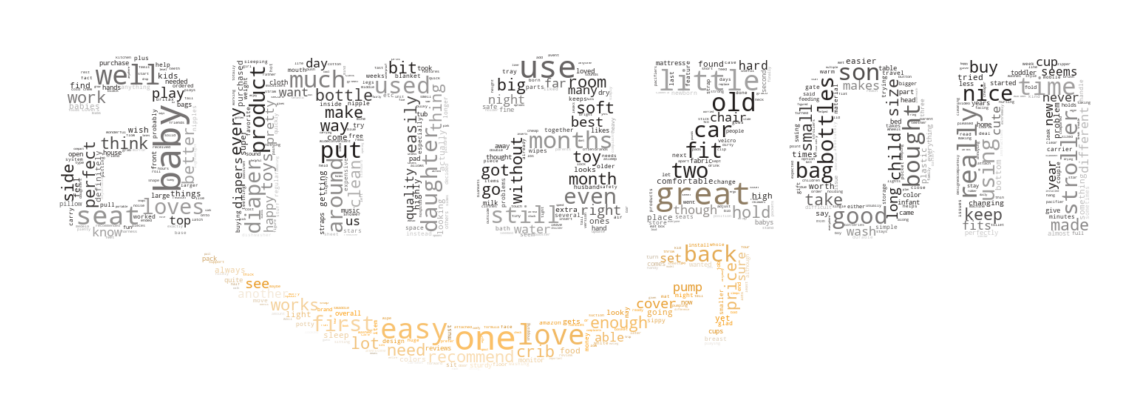

In [83]:
import os
from PIL import Image
from os import path, getcwd
from wordcloud import WordCloud, ImageColorGenerator
d = os.getcwd()
mask = np.array(Image.open(path.join(d, "amazon.jpg")))
wc = WordCloud(background_color="white", max_words=700, mask=mask,
               repeat = False, min_word_length=2, collocations=False, normalize_plurals = False,
               max_font_size=50, random_state=125)
wc.generate((text_pos2.replace("quot",""))) # Remove the string "quot" found in Amazon reviews that use quotation marks
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
_=plt.show()

### Negative Word Cloud

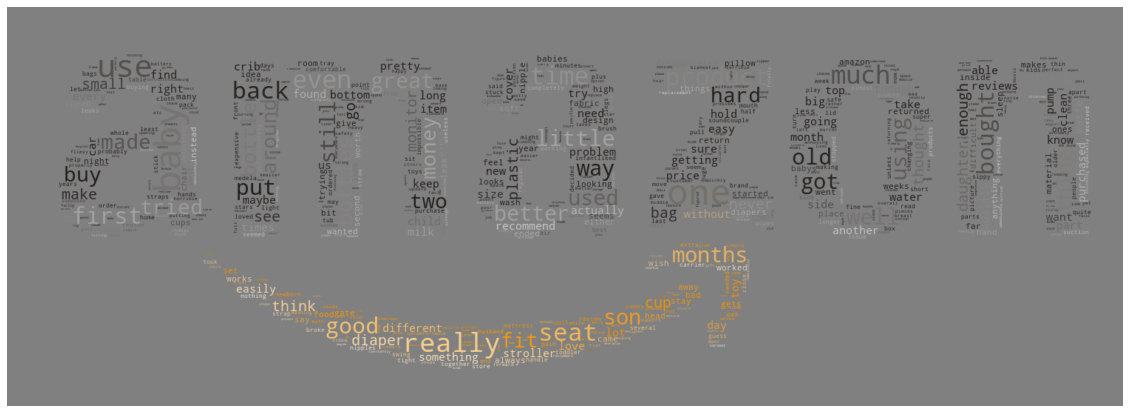

In [84]:
mask = np.array(Image.open(path.join(d, "amazon.jpg")))
wc = WordCloud(background_color="grey", max_words=700, mask=mask,
               repeat = False, min_word_length=2, collocations=False, normalize_plurals = False,
               max_font_size=50, random_state=125)
wc.generate((text_neg2.replace("quot",""))) # Remove the string "quot" found in Amazon reviews that use quotation marks
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
_=plt.show()